# Optimization

In this notebook we are going to optimize for a homogeneous intensity distribution and measure our achievements.

In [37]:
import os
import control
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

os.makedirs('../dataset/optimization', exist_ok=True)

duration = 26.84e-3
f_start = 90e6
f_stop = 110e6

scope = control.MSOX6004A('172.22.22.30')
scope.holla()

'AGILENT TECHNOLOGIES,MSO-X 4054A,MY57310545,07.20.2017102615\n'

Use the below cell to manually adjust the oscilloscope window to fit the signal.

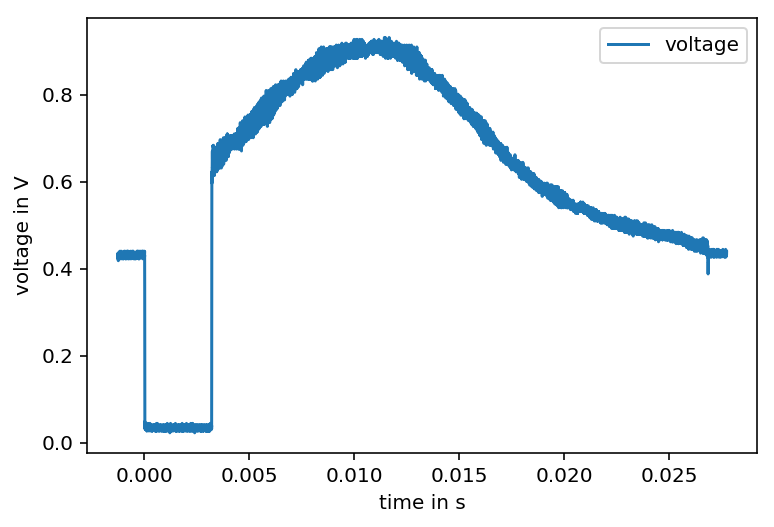

In [38]:
control.aod_h(frequency=100e6)
control.aod_v(frequency=[f_start, f_stop], duration=duration, amplitude=np.ones(1024), nodwells=[False, True])

df = scope.capture()
df.plot('time', 'voltage')

plt.xlabel('time in s')
plt.ylabel('voltage in V')
plt.show()

In the above plot we can see three jumps. The first jump at about 0ms marks the external trigger. The third jump at about 26.84ms marks the end of the frequency sweep. For some, yet unknown, reason there is a delay, propably originating from the synthesizer, where there is no signal. The second jump can be found at the index where the voltage difference between
two subsequent values is a maximum.

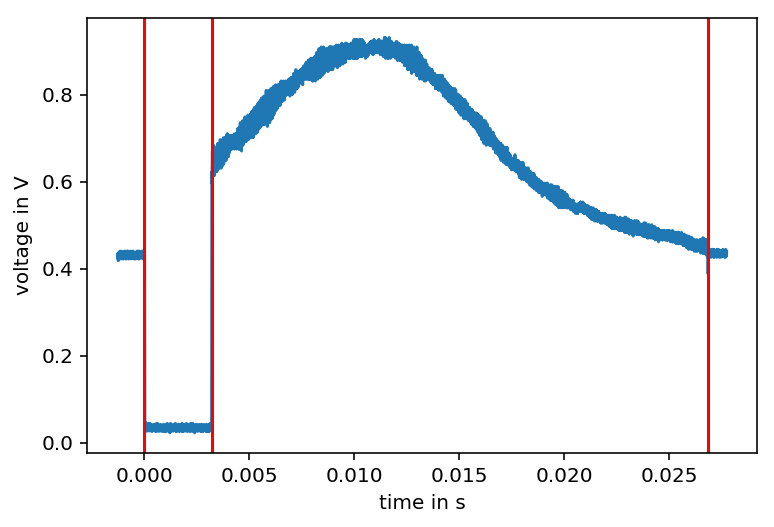

In [39]:
t_start = df.time[df.voltage.diff().idxmax()]
t_stop = duration

plt.plot(df.time, df.voltage)
plt.axvline(0, c='red')
plt.axvline(t_start, c='red')
plt.axvline(t_stop, c='red')
plt.xlabel('time in s')
plt.ylabel('voltage in V')
plt.show()

So the only usable data is between the second and third jump. In the next step we add a frequency scale.

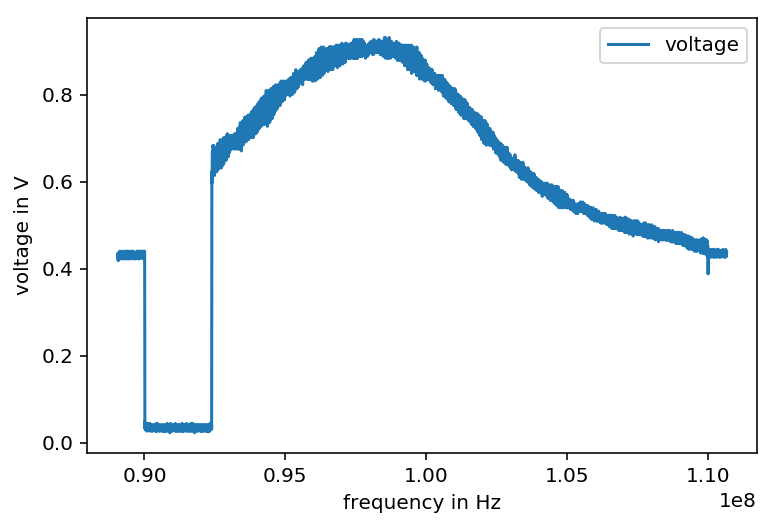

In [42]:
df['frequency'] = f_start + (f_stop - f_start) * df.time / duration
df.plot('frequency', 'voltage')

plt.xlabel('frequency in Hz')
plt.ylabel('voltage in V')
plt.show()

The synthesizer memory gives us space for 1024 discrete amplitude values. The oscilloscope, however gives us a much higher resolution. We will downscale the region of interest down to 1024 to allow a one to one mapping.

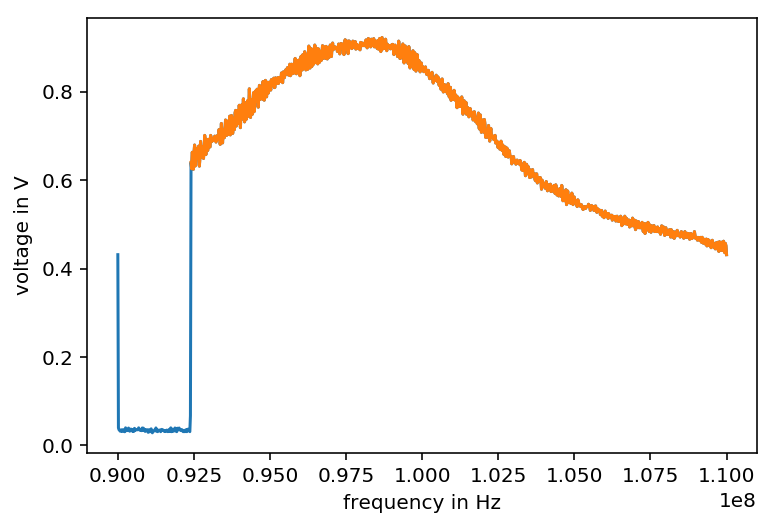

In [60]:
def downscale(x, N=1024):
    i = np.linspace(0, 1, len(x))
    j = np.linspace(0, 1, N)

    return np.interp(j, i, x)

t = df[(df.time > 0) & (df.time < duration)].time
f = df[(df.time > 0) & (df.time < duration)].frequency
U = df[(df.time > 0) & (df.time < duration)].voltage

ds = pd.DataFrame({
    'frequency': downscale(f),
    'voltage': downscale(U),
    'time': downscale(t)
})
dc = ds[ds.time > t_start]

plt.plot(ds.frequency, ds.voltage)
plt.plot(dc.frequency, dc.voltage)
plt.xlabel('frequency in Hz')
plt.ylabel('voltage in V')
plt.show()

We are now going to optimize only on the values of the orange region.

In [64]:
N = len(dc)
U_min = dc.voltage.min()

N, U_min

(901, 0.43137949056)

Objective we want to find the function that maps a given intensity to an amplitude:

$$
\begin{align}
f\colon\mathbb{R}_+^N&\to ]0,1]^N\\
f(\mathbf{I})&\mapsto \mathbf{A}
\end{align}
$$

From the previous cell we know that the *best* intensity we can reach (assuming lower amplitude values cause lower intensities) is $U_\text{min}$, henceforth $(A_1,\dots,A_N)=f(U_\text{min})$ is what we want in the end and what we will optimize on.

In [79]:
import torch

from torch import optim
from torch import nn
from torch.nn import functional as F

In [106]:
def sample():
    return np.random.random_sample(N)

def measure(A):
    control.aod_h(frequency=100e6)
    control.aod_v(frequency=[f_start, f_stop], duration=duration, amplitude=A, nodwells=[False, True])

    df = scope.capture()

    return downscale(df[(df.time > 0) & (df.time < duration)].voltage)

In [108]:
weight = 5 * torch.randn(4, 1).double()
bias = 5 * torch.randn(1).double()

optimizer = optim.Adam(net.parameters(), lr=.2)

def optimize(A, I):    
    inputs = torch.from_numpy(I[np.newaxis, np.newaxis, -N:])
    targets = torch.from_numpy(A[np.newaxis, np.newaxis, -N:])
    outputs = net(inputs)

    optimizer.zero_grad()
    
    loss = F.mse_loss(outputs, targets)
    loss.backward()
    
    optimizer.step()
    
    print(f'loss: {loss.item()}')

In [109]:
for i in range(100):
    A = sample()
    I = measure(A)
    
    optimize(A, I)

loss: 0.3647605831917556
loss: 0.2298163397802892
loss: 0.14570412009682543
loss: 0.13128650344317686
loss: 0.12007321678359596
loss: 0.11646388424005265
loss: 0.13066086946284566
loss: 0.13109707680343416
loss: 0.1957052505499045
loss: 0.16934210629409133
loss: 0.1521105776481354
loss: 0.14028825067827946
loss: 0.12740724532698894
loss: 0.14933942557549726
loss: 0.13155423300187832
loss: 0.1281122010186943
loss: 0.1511201720450221
loss: 0.1318528378451722
loss: 0.13876350079762184
loss: 0.12098431119054115
loss: 0.12109140744218971
loss: 0.1227508866286916
loss: 0.1370768638789003
loss: 0.13325857205508543
loss: 0.145431478439502
loss: 0.13597706650455046
loss: 0.1322413159434815
loss: 0.12654195626159348
loss: 0.1247146572765465
loss: 0.12256014864529625
loss: 0.12636367461575052
loss: 0.11576247949843714
loss: 0.12153921625977358
loss: 0.1081033757096868
loss: 0.11788240659072945
loss: 0.1478976413227111
loss: 0.11204053213488516
loss: 0.10818425500728174
loss: 0.14168333157540602
l

In [113]:
#A = sample()
A = 1*np.ones(1024)
I = measure(A)
    
inputs = torch.from_numpy(I[np.newaxis, np.newaxis, -N:])
targets = torch.from_numpy(A[np.newaxis, np.newaxis, -N:])
outputs = net(inputs)

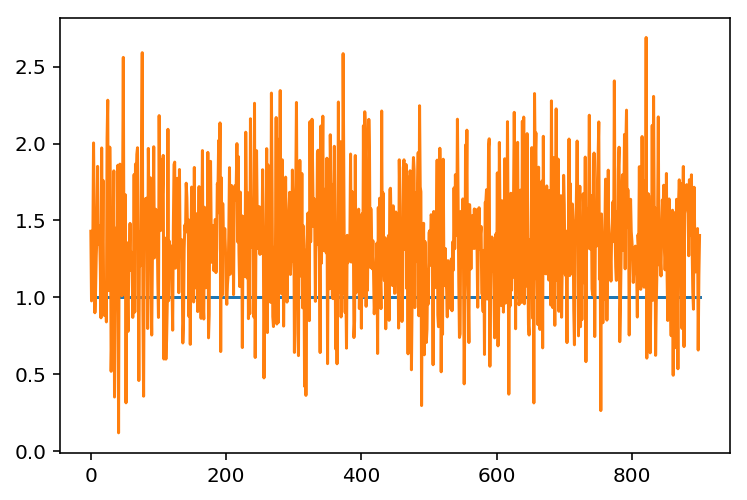

In [114]:
plt.plot(targets.detach().numpy()[0, 0])
plt.plot(outputs.detach().numpy()[0, 0])

In [94]:
control.aod_h(frequency=100e6)
control.aod_v(frequency=[f_start, f_stop], duration=duration, amplitude=z.clip(0, 1), nodwells=[False, True])

df = scope.capture()